In [88]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns

from IPython.display import Markdown as md
from matplotlib_venn import venn3, venn2
from tracking_grants.utils.helpers import load_references, load_articles, load_metrics, load_awards, load_grants, load_trials

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

In [118]:
sns.set_context("talk")

# Color palette
cm = "Paired"
cp3 = sns.color_palette(cm, 3)
cp10 = sns.color_palette(cm, 10)

# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

In [62]:
refs = load_references()
articles = load_articles()
metrics = load_metrics()
awards = load_awards()
trials = load_trials()
grants = load_grants()

In [63]:
# Some report-specific processing

metrics.wos_citations.replace(0, np.nan, inplace=True)
metrics.twitter_accounts.replace(0, np.nan, inplace=True)
metrics.news_outlets.replace(0, np.nan, inplace=True)

# remove some observations from dataset
# grants = grants[grants.program!="PRORP"]
grants = grants[grants.award_amount!=0]
grants.wos_citations = grants.wos_citations.replace(0, None)

# award categories coded by Lauren
grant_cats = pd.read_excel("/home/asura/Projects/scholcommlab/tracking-grants/data/external/CDRMP_award_types.xlsx")
df = grant_cats.category.dropna().map(lambda x: [s.strip() for s in x.split("/")])
cats = grant_cats[['award type', 'publication count']].join(df.to_frame().explode("category"), how="right")
grants = grants.merge(cats[['award type', 'category']], left_on="type", right_on="award type", how="left")
grants.loc[grants.category.isna(), 'category'] = "Other"

In [64]:
select_cols = ["wos_citations", "twitter_accounts", "news_outlets"]
col_labels = ["citations", "twitter", "news"]

for c, l in zip(select_cols, col_labels):
    metrics.rename(columns={c:l}, inplace=True)
    grants.rename(columns={c:l}, inplace=True)

## Top/bottom 5 articles

Top and bottom 5 articles with most cited, top 5 most Tweeted, most news. Include number for each.

In [76]:
def top_bottom(metric, input_df, columns):
    df = input_df[columns].copy()
    
    df[[_+"_rank" for _ in columns]] = df.rank(ascending=False, method="min")
    df = df.sort_values(metric, ascending=False)
    df = df.dropna(subset=[metric])

    max_rank = df[metric+"_rank"].max()
    top_bottom = [1, 2, 3, 4, 5]
    top_bottom.extend(list(range(int(max_rank)-4, int(max_rank+1))))

    df = df[df[metric+"_rank"].isin(top_bottom)]

    return df[sorted(df.columns)]

In [77]:
for c in col_labels:
    df = top_bottom(c, metrics.drop_duplicates(subset=["DOI"]), col_labels)
    df.index.name = "id"
    df = df.merge(metrics[['program', 'DOI']], left_index=True, right_index=True)
    df.to_csv(f"articles_{c}.csv")

## Top/bottom 5 grants

Top and bottom 5 grants with most average citations, tweets, and news. Incl. Num articles. and total award size

In [78]:
for c in col_labels:
    df = top_bottom(c, grants.drop_duplicates(subset=["grant_id"]), col_labels)
    df.index.name = "id"
    df = df.merge(grants[['program', 'grant_id', 'type', 'n_dois', 'authors_count', 'award_amount']], left_index=True, right_index=True)
    df.to_csv(f"grants_{c}.csv")

## Top/bottom 5 grants per \\$

Top and bottom 5 grants with most citations per \\$, tweets per \\$, news per \\$

In [73]:
per_dollar_columns = ["citations_per_$", "twitter_per_$", "news_per_$"]
grants[per_dollar_columns] = grants[col_labels].div(grants.award_amount, axis=0)

In [80]:
for c in per_dollar_columns:
    df = top_bottom(c, grants.drop_duplicates("grant_id"), per_dollar_columns)
    df.index.name = "id"
    df = df.merge(grants[['program', 'grant_id', 'type', 'n_dois', 'authors_count', 'award_amount']], left_index=True, right_index=True)
    df.to_csv(f"grants_{c}.csv")

## Linear Regression

Can you run a linear regression on Award Size vs Number of Publications and on Award Size vs Number of Citations? I'd like to know the slope of the line as well as the R^2. 

#### Award size vs Number of Publications

In [111]:
df = grants.drop_duplicates("grant_id")[['award_amount', 'n_dois']]

X = pd.DataFrame(df['award_amount'])
y = pd.DataFrame(df['n_dois'])

reg = LinearRegression().fit(X, y)
r2 = reg.score(X, y)
intercept = reg.intercept_[0]
slope = reg.coef_[0][0]

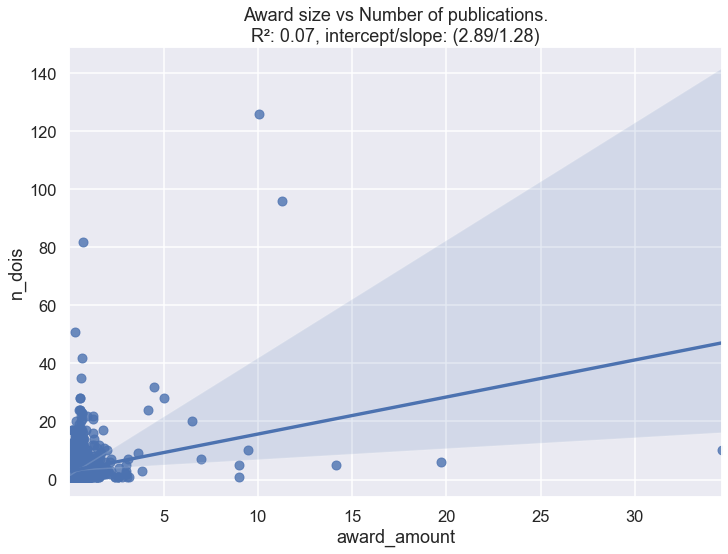

In [120]:
sns.regplot(x="award_amount", y="n_dois", data=df)

plt.title(f"Award size vs Number of publications.\nR²: {r2:.2f}, intercept/slope: ({intercept:.2f}/{slope:.2f})");

#### Award size vs Number of Citations

In [123]:
df = grants.drop_duplicates("grant_id")[['award_amount', 'citations']].dropna()

X = pd.DataFrame(df['award_amount'])
y = pd.DataFrame(df['citations'])

reg = LinearRegression().fit(X, y)
r2 = reg.score(X, y)
intercept = reg.intercept_[0]
slope = reg.coef_[0][0]

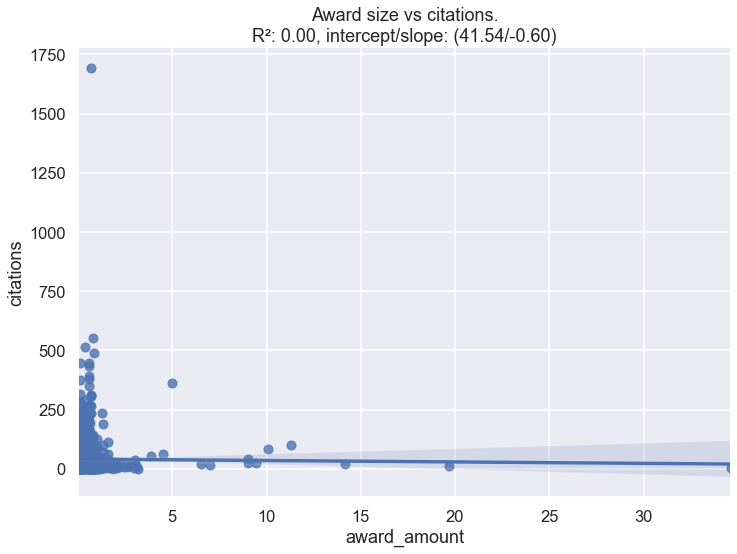

In [126]:
sns.regplot(x="award_amount", y="citations", data=df)

plt.title(f"Award size vs citations.\nR²: {r2:.2f}, intercept/slope: ({intercept:.2f}/{slope:.2f})");